# QBF
## Quant test task

* by Ainur Kazykhanov

### Import libraries 

In [1]:
from __future__ import print_function
from sklearn.externals import joblib
import pandas as pd
import numpy as np
import os
import time
import warnings
warnings.filterwarnings('ignore')

### Import classes

In [2]:
from data_fn import Data
from alpha_fn import Alpha
from fit_fn import Fit
from simulation_fn import Simulation
from evaluation_fn import Evaluation

Using TensorFlow backend.


## Description

* Chosen strategy works with daily data and rebalance portfolio every day at market open.
* Model trains on historical data and returns predictions of every day close price.
* Core model consists of two neural networks working with different sets of targets aimed to predict single value and sequences.
* Final prediction is a linear combination of these two predictions.

## Assumptions

- The configuration for the model was found after a little trial and error and is by no means optimized! Calibrating the model parameters is a long journey. Anyway current set of parameters does not 'suffer' a lot from high bias / high variance.

## Config

* __options.ini__ file with all necessary parameters stored in 'data/' folder.
* __copy__ in 'data/config_copy/'.

## Data

__Brief description:__
* Pre-process given raw data and converts it to data object containing data matrices of following format (stocks * days).

__Prepare data:__
* Resample given data to 1-day format.
* Select only following stocks:
    * enough data for analysis.
    * maximum gap length is 1.
    * have information about corporate events.
    * company corporate events actual history do not include chosen events.
* Get EPS events.
* Get Dividend events.
* Get sector codes.
* Adjust data on stock splits and dividends.

In [3]:
# Convert raw data to required format.
# : input: given raw data.
# : return: -
# : store: save data object to disk.
Data().prepare_data()

Prepare data: 
  stocks: 662 (start)
  stocks: 447 (end)
data completed.


## Alpha

__Brief description:__
* Derive alphas from given data.

__Alphas list:__
1.  __A__: adv
2.  __A__: open p. momentum (1d)
3.  __A__: high p. momentum (1d)
4.  __A__: low p. momentum (1d)
5.  __A__: close p. momentum (1d)
6.  __A__: momentum (3d)
7.  __A__: momentum (10d)
8.  __A__: momentum (21d)
9.  __A__: momentum (70d)
10. __A__: momentum (130d)
11. __A__: sma (7d)
12. __A__: sma (21d)
13. __A__: macd
14. __A__: bollinger bands
15. __A__: standard deviation
16. __A__: information ratio
17. __A__: iqr
18. __A__: 10% percentile
19. __A__: 25% percentile
20. __A__: 75% percentile
21. __A__: 90% percentile
22. __A__: positive cross count
23. __A__: negative cross count
24. __A__: median return
25. __A__: mean return (3d)
26. __A__: mean return (5d)
27. __A__: mean return (10d)
28. __A__: mean return (21d)
29. __A__: mean reversion (3d)
30. __A__: mean reversion (5d)
31. __A__: mean reversion (10d)
32. __A__: mean reversion (21d)
33. __A__: dividends regular cash yield constant
34. __A__: dividends regular cash yield relative
35. __A__: dividends special cash yield constant
36. __A__: dividends special cash yield relative
37. __A__: eps earnings yield constant
38. __A__: eps earnings yield relative
39. __A__: eps earnings-estimate yield constant
40. __A__: eps earnings-estimate yield relative
41. __A__: eps earnings-comparable yield constant
42. __A__: eps earnings-comparable yield relative
43. __E__: dividends regular
44. __E__: dividends special
45. __E__: eps earnings
46. __E__: eps comparable
47. __E__: eps estimate
48. __T__: original data
49. __T__: wavelet transform

__WARNING!__ 
__It takes a lot of time.__

In [4]:
# Create alphas.
# : input: data object.
# : return: -
# : store: save alphas to disk.
Alpha().run_alphas()


Create alphas|events|tensors:
  building tensor: open
    tensor done
  building tensor: high
    tensor done
  building tensor: low
    tensor done
  building tensor: close
    tensor done
  building tensor: adv
    tensor done
  alphas: 47
alphas completed


## Fit

__Brief description:__
* Train the model on given set of alphas-labels and return predictions on each day.

__Prepare data:__
- Feature Eng: 
    - d-SAE model extracts high level deep features from given alpha matrix.
- Feature selection: 
    - gBoosting based feature importance filter drops irrelevant features.
- Stacking (alpha): 
    - add events to alpha matrix.
- Stacking (alpha): 
    - bayesian ridge model predicts target values and stack predictions to alpha matrix. 
- Stacking (target): 
    - add two more days to target matrix (original).
- Stacking (target): 
    - add total return (3 days) to target values (original).

__Model:__
* __ALPHA:__ 
    * 2-rRNet w/ DeepConv features in pair with Seq2Seq DeepConv-GRU predict '3 day+total' and '3 day' returns.  
* __BETA:__ 
    * 2-rRNet in pair with Feature Pyramid Network predict '1 day' return.  

__Prediction:__
* Predictions are made using MC Dropout sampling and weighting sequence predictions together with single day forecasts.

__Details__:
- First training (general): 
    - general + fine tuning of all layers. 
- Transfer learning (if activated): 
    - transfer learning with newly initialized last layers + fine tuning of all layers + freezing.
    - model freeze selected layers for a certain period of time specified in options.ini, after a given period layers become trainable again.

__WARNING!__
__It takes a lot of time.__

In [5]:
# Fit the model.
# : input: data object and alphas.
# : return: predicted positions matrix
# : store: save predictions to disk.
positions_strategy = Fit().run_model()


Fit model:
Days available: 2037
Data size: 1.93Gb

  Fitting on 20160104
      vars. loaded
          autoencoder trained
          gradient boosting regression trained
          bayesian ridge regression trained
      pre-model phase completed
      training neural network - ALPHA
Epoch 1/8
 - 13s - loss: 2.6808 - dense_14_loss: 2.3318 - dense_15_loss: 1.0378
Epoch 2/8
 - 7s - loss: 1.9622 - dense_14_loss: 1.6313 - dense_15_loss: 1.0366
Epoch 3/8
 - 7s - loss: 1.8430 - dense_14_loss: 1.5929 - dense_15_loss: 1.0365
Epoch 4/8
 - 7s - loss: 1.7596 - dense_14_loss: 1.5819 - dense_15_loss: 1.0359
Epoch 5/8
 - 8s - loss: 1.6905 - dense_14_loss: 1.5708 - dense_15_loss: 1.0354
Epoch 6/8
 - 8s - loss: 1.6418 - dense_14_loss: 1.5665 - dense_15_loss: 1.0348
Epoch 7/8
 - 8s - loss: 1.6035 - dense_14_loss: 1.5606 - dense_15_loss: 1.0343
Epoch 8/8
 - 8s - loss: 1.5738 - dense_14_loss: 1.5548 - dense_15_loss: 1.0338
Epoch 1/2
 - 8s - loss: 1.5585 - dense_14_loss: 1.5564 - dense_15_loss: 1.0327
Epoc

Epoch 1/8
 - 13s - loss: 1.8103 - dense_49_loss: 1.8529 - dense_50_loss: 1.2362
Epoch 2/8
 - 7s - loss: 1.7862 - dense_49_loss: 1.8289 - dense_50_loss: 1.2237
Epoch 3/8
 - 7s - loss: 1.7797 - dense_49_loss: 1.8222 - dense_50_loss: 1.2211
Epoch 4/8
 - 7s - loss: 1.7760 - dense_49_loss: 1.8186 - dense_50_loss: 1.2199
Epoch 5/8
 - 7s - loss: 1.7744 - dense_49_loss: 1.8173 - dense_50_loss: 1.2193
Epoch 6/8
 - 10s - loss: 1.7745 - dense_49_loss: 1.8175 - dense_50_loss: 1.2191
Epoch 7/8
 - 9s - loss: 1.7732 - dense_49_loss: 1.8162 - dense_50_loss: 1.2188
Epoch 8/8
 - 9s - loss: 1.7719 - dense_49_loss: 1.8149 - dense_50_loss: 1.2189
Epoch 1/2
 - 8s - loss: 1.7641 - dense_49_loss: 1.8062 - dense_50_loss: 1.2146
Epoch 2/2
 - 8s - loss: 1.7656 - dense_49_loss: 1.8080 - dense_50_loss: 1.2143
Epoch 1/2
 - 2s - loss: 1.6487 - dense_49_loss: 1.6880 - dense_50_loss: 1.1310
Epoch 2/2
 - 2s - loss: 1.6532 - dense_49_loss: 1.6923 - dense_50_loss: 1.1361
Epoch 1/2
 - 4s - loss: 1.7745 - dense_49_loss: 1.

## Simulation

__Brief description:__
* PnL modeling on day to day basis.

__Prepare data:__
* Balancing long-short positions.
* Slowing down trading applying basic smoothing.
* Industry neutralization.
* Selecting N best stocks in both directions.

__Details:__
* Commissions: Interactive Brokers.
* Price Slippage: None

__Assumptions:__
* No borrowing costs.
* No cash borrowing for long positions.
* Immediate trade settlement.

In [3]:
# Load positions matrix.
positions_strategy = joblib.load('data/pp_data/positions/positions.pickle')

In [4]:
# Run simulation
# : input: predicted positions matrix
# : return: sim object
# : store: -
strategy = Simulation(positions_strategy).run_simulation()


Simulation started:
Initial funds: $1,000,000

Description:
   PnL: pnl
   C:   cash
   L:   longs
   S:   shorts
   E:   equity
   AF:  available funds
   EL:  excess liquidity
   SMA: special memorandum account
   BP:  buying power
   L:   leverage

Trading date: 2016-01-04 00:00:00. (day: 0)
PnL: 0. C: 1,000,000. L: 0. S: 0. E: 1,000,000. AF: 1,000,000. EL: 1,000,000. SMA: 1,000,000. BP: 2,000,000. L: 1.00.
PnL: -142. C: 1,996,660. L: 0. S: -996,802. E: 999,858. AF: 501,458. EL: 695,267. SMA: 501,458. BP: 1,002,915. L: 1.00.
PnL: -486. C: 999,489. L: 996,826. S: -996,802. E: 999,514. AF: 2,700. EL: 298,207. SMA: 2,700. BP: 5,400. L: 0.50.
PnL: 4,394. C: 999,489. L: 1,004,618. S: -999,713. E: 1,004,394. AF: 2,229. EL: 300,991. SMA: 2,700. BP: 5,400. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-01-05 00:00:00. (day: 1)
PnL: -666. C: 999,489. L: 1,006,517. S: -1,002,277. E: 1,003,72

PnL: -1,327. C: 1,056,958. L: 834,520. S: -974,084. E: 917,394. AF: 13,092. EL: 249,134. SMA: 16,209. BP: 32,417. L: 0.51.
PnL: -1,433. C: 926,530. L: 898,797. S: -908,039. E: 917,288. AF: 13,870. EL: 241,788. SMA: 13,870. BP: 27,739. L: 0.51.
PnL: 11,570. C: 926,530. L: 915,123. S: -911,361. E: 930,291. AF: 17,049. EL: 234,289. SMA: 17,049. BP: 34,098. L: 0.51.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-01-22 00:00:00. (day: 13)
PnL: 11,319. C: 926,585. L: 940,435. S: -925,410. E: 941,610. AF: 8,688. EL: 234,957. SMA: 17,104. BP: 34,208. L: 0.50.
PnL: 11,161. C: 1,101,656. L: 848,290. S: -1,008,495. E: 941,452. AF: 13,059. EL: 260,949. SMA: 21,476. BP: 42,952. L: 0.51.
PnL: 11,062. C: 955,168. L: 921,474. S: -935,288. E: 941,354. AF: 12,973. EL: 259,664. SMA: 12,973. BP: 25,945. L: 0.51.
PnL: -2,730. C: 955,168. L: 911,955. S: -939,563. E: 927,561. AF: 1,802. EL: 248,160. SMA: 12,973. BP: 

Trading date: 2016-02-09 00:00:00. (day: 25)
PnL: -7,927. C: 936,588. L: 876,246. S: -900,580. E: 912,254. AF: 23,841. EL: 314,234. SMA: 23,841. BP: 47,681. L: 0.51.
PnL: -8,012. C: 1,119,070. L: 819,243. S: -1,026,145. E: 912,168. AF: -10,526. EL: 294,153. SMA: -10,526. BP: -21,051. L: 0.49.
PnL: -8,131. C: 935,481. L: 886,039. S: -909,471. E: 912,049. AF: 14,294. EL: 303,715. SMA: 14,294. BP: 28,588. L: 0.51.
PnL: -5,969. C: 935,481. L: 897,214. S: -918,484. E: 914,212. AF: 6,363. EL: 308,154. SMA: 14,294. BP: 28,588. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-02-10 00:00:00. (day: 26)
PnL: 1,943. C: 935,200. L: 903,729. S: -922,774. E: 916,154. AF: 2,903. EL: 297,902. SMA: 14,013. BP: 28,026. L: 0.50.
PnL: 1,854. C: 1,151,186. L: 785,282. S: -1,020,403. E: 916,066. AF: 13,223. EL: 303,603. SMA: 24,333. BP: 48,667. L: 0.51.
PnL: 1,691. C: 922,748. L: 899,179. S: -906,025. E: 915,

PnL: 9,763. C: 979,591. L: 945,461. S: -955,857. E: 969,195. AF: 18,536. EL: 359,708. SMA: 18,536. BP: 37,071. L: 0.51.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-02-29 00:00:00. (day: 38)
PnL: 1,860. C: 979,630. L: 945,950. S: -954,526. E: 971,054. AF: 20,816. EL: 361,518. SMA: 20,816. BP: 41,633. L: 0.51.
PnL: 1,761. C: 1,137,095. L: 897,905. S: -1,064,044. E: 970,956. AF: -10,019. EL: 344,308. SMA: -10,019. BP: -20,037. L: 0.49.
PnL: 1,646. C: 986,522. L: 951,587. S: -967,268. E: 970,841. AF: 11,414. EL: 356,581. SMA: 11,414. BP: 22,827. L: 0.51.
PnL: 4,881. C: 986,522. L: 948,410. S: -960,856. E: 974,076. AF: 19,443. EL: 362,729. SMA: 19,443. BP: 38,886. L: 0.51.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-03-01 00:00:00. (day: 39)
PnL: 2,461. C: 986,544. L: 958,901. S: -968,908. E: 976,537. 

Trading date: 2016-03-16 00:00:00. (day: 50)
PnL: -1,625. C: 1,027,539. L: 987,264. S: -1,010,193. E: 1,004,610. AF: 5,881. EL: 362,286. SMA: 10,070. BP: 20,140. L: 0.50.
PnL: -1,716. C: 1,198,525. L: 931,787. S: -1,125,794. E: 1,004,518. AF: -24,272. EL: 343,982. SMA: -20,083. BP: -40,167. L: 0.49.
PnL: -1,856. C: 1,017,744. L: 988,013. S: -1,001,378. E: 1,004,378. AF: 9,683. EL: 366,775. SMA: 9,683. BP: 19,365. L: 0.50.
PnL: 3,869. C: 1,017,744. L: 1,004,316. S: -1,011,956. E: 1,010,104. AF: 1,968. EL: 364,827. SMA: 9,683. BP: 19,365. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-03-17 00:00:00. (day: 51)
PnL: 614. C: 1,017,848. L: 1,005,239. S: -1,012,369. E: 1,010,718. AF: 1,914. EL: 364,991. SMA: 9,787. BP: 19,574. L: 0.50.
PnL: 486. C: 1,159,765. L: 955,592. S: -1,104,767. E: 1,010,589. AF: -19,590. EL: 346,327. SMA: -11,717. BP: -23,433. L: 0.49.
PnL: 394. C: 1,017,227. L: 1,00

PnL: -408. C: 1,159,167. L: 949,887. S: -1,095,551. E: 1,013,504. AF: -9,216. EL: 347,375. SMA: 1,196. BP: 2,393. L: 0.50.
PnL: -517. C: 1,015,598. L: 1,007,675. S: -1,009,879. E: 1,013,394. AF: 4,617. EL: 351,439. SMA: 4,617. BP: 9,234. L: 0.50.
PnL: -5,268. C: 1,015,598. L: 997,831. S: -1,004,786. E: 1,008,644. AF: 7,335. EL: 349,898. SMA: 7,335. BP: 14,671. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-04-05 00:00:00. (day: 63)
PnL: -3,579. C: 1,015,598. L: 987,644. S: -998,178. E: 1,005,064. AF: 12,153. EL: 350,893. SMA: 12,153. BP: 24,307. L: 0.51.
PnL: -3,685. C: 1,177,597. L: 913,906. S: -1,086,544. E: 1,004,959. AF: 4,734. EL: 346,543. SMA: 4,734. BP: 9,468. L: 0.50.
PnL: -3,795. C: 995,466. L: 1,002,466. S: -993,083. E: 1,004,848. AF: 7,074. EL: 339,486. SMA: 7,074. BP: 14,147. L: 0.50.
PnL: -2,860. C: 995,466. L: 1,000,275. S: -989,958. E: 1,005,783. AF: 10,667. EL: 341,805.

PnL: 5,164. C: 1,038,758. L: 1,054,914. S: -1,036,629. E: 1,057,043. AF: 11,271. EL: 381,508. SMA: 11,271. BP: 22,543. L: 0.51.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-04-21 00:00:00. (day: 75)
PnL: 1,809. C: 1,038,751. L: 1,056,787. S: -1,036,685. E: 1,058,852. AF: 12,116. EL: 382,610. SMA: 12,116. BP: 24,232. L: 0.51.
PnL: 1,709. C: 1,170,247. L: 1,007,819. S: -1,119,314. E: 1,058,752. AF: -4,815. EL: 373,438. SMA: -4,815. BP: -9,631. L: 0.50.
PnL: 1,614. C: 1,067,880. L: 1,045,788. S: -1,055,012. E: 1,058,657. AF: 8,257. EL: 380,016. SMA: 8,257. BP: 16,514. L: 0.50.
PnL: 3,705. C: 1,067,880. L: 1,039,157. S: -1,046,290. E: 1,060,748. AF: 18,024. EL: 387,172. SMA: 18,024. BP: 36,048. L: 0.51.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-04-22 00:00:00. (day: 76)
PnL: 1,296. C: 1,067,880. L: 1

------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-05-09 00:00:00. (day: 87)
PnL: -4,982. C: 1,011,263. L: 1,026,477. S: -1,014,707. E: 1,023,032. AF: 2,440. EL: 361,347. SMA: 9,692. BP: 19,383. L: 0.50.
PnL: -5,108. C: 1,196,761. L: 939,909. S: -1,113,764. E: 1,022,906. AF: -3,931. EL: 358,487. SMA: 3,321. BP: 6,641. L: 0.50.
PnL: -5,193. C: 1,027,984. L: 1,014,233. S: -1,019,396. E: 1,022,821. AF: 6,006. EL: 361,090. SMA: 6,006. BP: 12,013. L: 0.50.
PnL: -20,951. C: 1,027,984. L: 1,000,131. S: -1,021,052. E: 1,007,063. AF: -3,529. EL: 350,781. SMA: 6,006. BP: 12,013. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-05-10 00:00:00. (day: 88)
PnL: 110. C: 1,027,984. L: 1,004,606. S: -1,025,417. E: 1,007,173. AF: -7,838. EL: 347,101. SMA: 6,006. BP: 12,013. L: 0.50.
PnL: -12. C: 1,279,784. L: 899,549.

PnL: 2,151. C: 1,144,077. L: 945,779. S: -1,084,841. E: 1,005,015. AF: -10,296. EL: 324,034. SMA: 2,260. BP: 4,521. L: 0.49.
PnL: 2,059. C: 1,014,096. L: 991,994. S: -1,001,168. E: 1,004,923. AF: 8,342. EL: 334,131. SMA: 8,342. BP: 16,684. L: 0.50.
PnL: 14,729. C: 1,014,096. L: 1,006,192. S: -1,002,696. E: 1,017,593. AF: 13,149. EL: 339,301. SMA: 13,149. BP: 26,297. L: 0.51.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-05-26 00:00:00. (day: 100)
PnL: 5,755. C: 1,014,028. L: 1,012,524. S: -1,003,205. E: 1,023,347. AF: 15,482. EL: 341,323. SMA: 15,482. BP: 30,965. L: 0.51.
PnL: 5,633. C: 1,165,693. L: 941,282. S: -1,083,749. E: 1,023,226. AF: 10,710. EL: 347,573. SMA: 10,710. BP: 21,420. L: 0.51.
PnL: 5,547. C: 1,036,051. L: 1,006,864. S: -1,019,776. E: 1,023,140. AF: 9,820. EL: 347,078. SMA: 9,820. BP: 19,639. L: 0.50.
PnL: -8,004. C: 1,036,051. L: 993,437. S: -1,019,899. E: 1,009,589. AF: 2,9

PnL: -2,498. C: 1,007,874. L: 1,014,510. S: -1,005,450. E: 1,016,934. AF: 6,954. EL: 356,766. SMA: 6,954. BP: 13,909. L: 0.50.
PnL: -4,805. C: 1,007,874. L: 1,007,903. S: -1,001,151. E: 1,014,627. AF: 10,100. EL: 358,024. SMA: 10,100. BP: 20,200. L: 0.51.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-06-14 00:00:00. (day: 112)
PnL: -764. C: 1,008,032. L: 1,004,140. S: -998,310. E: 1,013,863. AF: 12,638. EL: 359,192. SMA: 12,638. BP: 25,275. L: 0.51.
PnL: -853. C: 1,081,638. L: 970,001. S: -1,037,865. E: 1,013,774. AF: 9,841. EL: 358,547. SMA: 9,841. BP: 19,681. L: 0.50.
PnL: -939. C: 1,015,308. L: 1,008,220. S: -1,009,840. E: 1,013,687. AF: 4,657. EL: 353,584. SMA: 4,657. BP: 9,315. L: 0.50.
PnL: -11,867. C: 1,015,308. L: 1,001,000. S: -1,013,548. E: 1,002,760. AF: -4,514. EL: 344,013. SMA: 4,657. BP: 9,315. L: 0.50.
-----------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-06-30 00:00:00. (day: 124)
PnL: 1,313. C: 993,808. L: 966,558. S: -979,963. E: 980,402. AF: 7,142. EL: 343,140. SMA: 13,958. BP: 27,915. L: 0.50.
PnL: 1,215. C: 1,089,843. L: 933,313. S: -1,042,851. E: 980,305. AF: -7,777. EL: 335,277. SMA: -962. BP: -1,923. L: 0.50.
PnL: 1,132. C: 1,001,461. L: 954,639. S: -975,879. E: 980,221. AF: 14,962. EL: 348,006. SMA: 14,962. BP: 29,924. L: 0.51.
PnL: -2,982. C: 1,001,461. L: 965,469. S: -990,823. E: 976,107. AF: -2,039. EL: 337,518. SMA: 14,962. BP: 29,924. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-07-01 00:00:00. (day: 125)
PnL: -1,288. C: 1,001,881. L: 963,564. S: -990,627. E: 974,819. AF: -2,277. EL: 336,587. SMA: 15,383. BP: 30,765. L: 0.50.
PnL: -1,391. C: 1,117,305. L: 930,496. S: -1,073,085. E: 

PnL: -2,944. C: 1,030,988. L: 1,015,042. S: -1,016,340. E: 1,029,690. AF: 13,998. EL: 372,520. SMA: 13,998. BP: 27,997. L: 0.51.
PnL: -3,004. C: 1,093,082. L: 988,587. S: -1,052,039. E: 1,029,630. AF: 9,317. EL: 370,099. SMA: 9,317. BP: 18,635. L: 0.50.
PnL: -3,112. C: 1,034,150. L: 1,021,330. S: -1,025,958. E: 1,029,522. AF: 5,878. EL: 366,973. SMA: 5,878. BP: 11,756. L: 0.50.
PnL: -10,346. C: 1,034,150. L: 1,016,908. S: -1,028,770. E: 1,022,288. AF: -551. EL: 359,808. SMA: 5,878. BP: 11,756. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-07-20 00:00:00. (day: 137)
PnL: -1,850. C: 1,034,098. L: 1,017,778. S: -1,031,438. E: 1,020,437. AF: -4,171. EL: 356,617. SMA: 5,825. BP: 11,651. L: 0.50.
PnL: -1,936. C: 1,145,232. L: 984,260. S: -1,109,139. E: 1,020,352. AF: -26,347. EL: 343,858. SMA: -16,351. BP: -32,701. L: 0.49.
PnL: -2,026. C: 1,024,234. L: 1,012,224. S: -1,016,197. E: 1,020,26

PnL: 1,348. C: 1,165,238. L: 979,621. S: -1,106,898. E: 1,037,961. AF: -5,299. EL: 366,464. SMA: -5,299. BP: -10,598. L: 0.50.
PnL: 1,276. C: 1,038,606. L: 1,033,588. S: -1,034,305. E: 1,037,889. AF: 3,943. EL: 371,129. SMA: 3,943. BP: 7,885. L: 0.50.
PnL: 1,971. C: 1,038,606. L: 1,035,231. S: -1,035,253. E: 1,038,584. AF: 3,342. EL: 369,861. SMA: 3,943. BP: 7,885. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-08-05 00:00:00. (day: 149)
PnL: 111. C: 1,038,606. L: 1,041,235. S: -1,041,146. E: 1,038,695. AF: -2,495. EL: 366,412. SMA: 3,943. BP: 7,885. L: 0.50.
PnL: 35. C: 1,219,726. L: 986,626. S: -1,167,732. E: 1,038,619. AF: -38,560. EL: 348,081. SMA: -32,122. BP: -64,243. L: 0.48.
PnL: -87. C: 1,038,073. L: 1,035,268. S: -1,034,844. E: 1,038,497. AF: 3,441. EL: 372,490. SMA: 3,441. BP: 6,883. L: 0.50.
PnL: 7,719. C: 1,038,073. L: 1,044,755. S: -1,036,525. E: 1,046,303. AF: 5,663. EL:

PnL: -2,856. C: 1,042,460. L: 1,043,961. S: -1,040,238. E: 1,046,182. AF: 4,083. EL: 367,378. SMA: 4,083. BP: 8,165. L: 0.50.
PnL: -4,509. C: 1,042,460. L: 1,043,431. S: -1,041,361. E: 1,044,530. AF: 2,134. EL: 365,421. SMA: 4,083. BP: 8,165. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-08-23 00:00:00. (day: 161)
PnL: 2,825. C: 1,042,494. L: 1,049,241. S: -1,044,380. E: 1,047,354. AF: 544. EL: 365,730. SMA: 4,116. BP: 8,233. L: 0.50.
PnL: 2,736. C: 1,131,698. L: 1,001,690. S: -1,086,122. E: 1,047,266. AF: 3,360. EL: 368,449. SMA: 6,933. BP: 13,866. L: 0.50.
PnL: 2,646. C: 1,044,401. L: 1,044,290. S: -1,041,515. E: 1,047,176. AF: 4,274. EL: 367,659. SMA: 4,274. BP: 8,548. L: 0.50.
PnL: 6,432. C: 1,044,401. L: 1,046,342. S: -1,039,781. E: 1,050,962. AF: 7,901. EL: 370,906. SMA: 7,901. BP: 15,801. L: 0.50.
---------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-09-09 00:00:00. (day: 173)
PnL: -1,465. C: 1,041,993. L: 1,033,294. S: -1,028,966. E: 1,046,322. AF: 15,192. EL: 373,035. SMA: 15,192. BP: 30,383. L: 0.51.
PnL: -1,555. C: 1,110,632. L: 1,005,641. S: -1,070,042. E: 1,046,232. AF: 8,390. EL: 370,094. SMA: 8,390. BP: 16,781. L: 0.50.
PnL: -1,639. C: 1,046,226. L: 1,042,878. S: -1,042,957. E: 1,046,148. AF: 3,230. EL: 364,923. SMA: 3,230. BP: 6,460. L: 0.50.
PnL: -6,120. C: 1,046,226. L: 1,017,336. S: -1,021,895. E: 1,041,667. AF: 22,051. EL: 373,561. SMA: 22,051. BP: 44,103. L: 0.51.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-09-12 00:00:00. (day: 174)
PnL: -2,021. C: 1,046,451. L: 1,011,450. S: -1,018,256. E: 1,039,646. AF: 24,793. EL: 374,313. SMA: 24,793. BP: 49,585. L: 0.51.
PnL: -2,099. C: 1,111,970.

Trading date: 2016-09-27 00:00:00. (day: 185)
PnL: -3,090. C: 1,041,438. L: 1,035,186. S: -1,028,382. E: 1,048,241. AF: 16,457. EL: 370,597. SMA: 17,716. BP: 35,432. L: 0.51.
PnL: -3,180. C: 1,135,881. L: 990,207. S: -1,077,937. E: 1,048,151. AF: 14,079. EL: 369,929. SMA: 15,338. BP: 30,676. L: 0.51.
PnL: -3,267. C: 1,059,473. L: 1,032,781. S: -1,044,190. E: 1,048,064. AF: 9,579. EL: 365,926. SMA: 9,579. BP: 19,158. L: 0.50.
PnL: -3,082. C: 1,059,473. L: 1,038,911. S: -1,050,135. E: 1,048,249. AF: 3,726. EL: 363,364. SMA: 9,579. BP: 19,158. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-09-28 00:00:00. (day: 186)
PnL: 2,064. C: 1,059,340. L: 1,043,189. S: -1,052,216. E: 1,050,313. AF: 2,610. EL: 363,197. SMA: 9,446. BP: 18,892. L: 0.50.
PnL: 1,975. C: 1,130,866. L: 1,001,718. S: -1,082,360. E: 1,050,224. AF: 8,184. EL: 367,565. SMA: 15,020. BP: 30,040. L: 0.50.
PnL: 1,884. C: 1,058,478

PnL: -2,785. C: 1,175,774. L: 1,005,019. S: -1,124,259. E: 1,056,534. AF: -8,104. EL: 357,440. SMA: -8,104. BP: -16,208. L: 0.50.
PnL: -2,875. C: 1,065,100. L: 1,044,281. S: -1,052,937. E: 1,056,444. AF: 7,836. EL: 366,162. SMA: 7,836. BP: 15,671. L: 0.50.
PnL: -160. C: 1,065,100. L: 1,050,022. S: -1,055,963. E: 1,059,160. AF: 6,167. EL: 366,685. SMA: 7,836. BP: 15,671. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-10-14 00:00:00. (day: 198)
PnL: -219. C: 1,065,379. L: 1,054,416. S: -1,060,854. E: 1,058,941. AF: 1,306. EL: 363,972. SMA: 8,115. BP: 16,229. L: 0.50.
PnL: -300. C: 1,234,784. L: 1,010,960. S: -1,186,884. E: 1,058,860. AF: -40,062. EL: 341,302. SMA: -33,254. BP: -66,508. L: 0.48.
PnL: -414. C: 1,063,708. L: 1,049,614. S: -1,054,576. E: 1,058,745. AF: 6,650. EL: 368,699. SMA: 6,650. BP: 13,301. L: 0.50.
PnL: -6,457. C: 1,063,708. L: 1,039,433. S: -1,050,438. E: 1,052,703. A

PnL: 3,014. C: 1,068,535. L: 1,063,835. S: -1,064,484. E: 1,067,886. AF: 3,727. EL: 363,711. SMA: 3,727. BP: 7,453. L: 0.50.
PnL: 679. C: 1,068,535. L: 1,059,664. S: -1,062,648. E: 1,065,551. AF: 4,395. EL: 362,855. SMA: 4,395. BP: 8,791. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-11-01 00:00:00. (day: 210)
PnL: 2,410. C: 1,068,692. L: 1,064,323. S: -1,065,054. E: 1,067,961. AF: 3,273. EL: 363,853. SMA: 4,552. BP: 9,105. L: 0.50.
PnL: 2,325. C: 1,233,714. L: 998,803. S: -1,164,641. E: 1,067,876. AF: -13,845. EL: 352,714. SMA: -12,566. BP: -25,131. L: 0.49.
PnL: 2,208. C: 1,068,344. L: 1,063,515. S: -1,064,101. E: 1,067,759. AF: 3,951. EL: 361,343. SMA: 3,951. BP: 7,902. L: 0.50.
PnL: -2,555. C: 1,068,344. L: 1,052,653. S: -1,058,002. E: 1,062,996. AF: 7,669. EL: 360,614. SMA: 7,669. BP: 15,338. L: 0.50.
-------------------------------------------------------------------------------

PnL: -5,885. C: 1,121,179. L: 1,091,241. S: -1,105,389. E: 1,107,031. AF: 8,717. EL: 398,159. SMA: 10,759. BP: 21,518. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-11-17 00:00:00. (day: 222)
PnL: 2,977. C: 1,121,141. L: 1,094,885. S: -1,106,017. E: 1,110,009. AF: 9,558. EL: 399,873. SMA: 10,721. BP: 21,442. L: 0.50.
PnL: 2,885. C: 1,243,374. L: 1,055,887. S: -1,189,345. E: 1,109,916. AF: -12,700. EL: 387,740. SMA: -11,536. BP: -23,073. L: 0.49.
PnL: 2,796. C: 1,120,528. L: 1,095,414. S: -1,106,116. E: 1,109,827. AF: 9,062. EL: 400,124. SMA: 9,062. BP: 18,124. L: 0.50.
PnL: 591. C: 1,120,528. L: 1,096,707. S: -1,109,614. E: 1,107,622. AF: 4,462. EL: 396,402. SMA: 9,062. BP: 18,124. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-11-18 00:00:00. (day: 223)
PnL: -515. C: 1,120,635. L: 1,

------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-12-06 00:00:00. (day: 234)
PnL: -2,300. C: 1,119,877. L: 1,119,403. S: -1,115,749. E: 1,123,531. AF: 5,955. EL: 410,495. SMA: 7,863. BP: 15,725. L: 0.50.
PnL: -2,373. C: 1,215,766. L: 1,072,330. S: -1,164,638. E: 1,123,458. AF: 4,974. EL: 410,432. SMA: 6,881. BP: 13,762. L: 0.50.
PnL: -2,476. C: 1,113,420. L: 1,120,201. S: -1,110,266. E: 1,123,355. AF: 8,122. EL: 411,370. SMA: 8,122. BP: 16,244. L: 0.50.
PnL: 6,080. C: 1,113,420. L: 1,131,525. S: -1,113,034. E: 1,131,911. AF: 9,632. EL: 416,317. SMA: 9,632. BP: 19,264. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-12-07 00:00:00. (day: 235)
PnL: 179. C: 1,113,061. L: 1,132,174. S: -1,113,144. E: 1,132,090. AF: 9,431. EL: 416,243. SMA: 9,431. BP: 18,863. L: 0.50.
PnL: 94. C: 1,206,089. L: 1,089,086

PnL: 772. C: 1,113,014. L: 1,108,530. S: -1,107,306. E: 1,114,239. AF: 6,321. EL: 406,537. SMA: 6,321. BP: 12,642. L: 0.50.
PnL: 666. C: 1,206,323. L: 1,061,396. S: -1,153,586. E: 1,114,133. AF: 6,642. EL: 406,920. SMA: 6,642. BP: 13,284. L: 0.50.
PnL: 591. C: 1,111,056. L: 1,109,095. S: -1,106,093. E: 1,114,058. AF: 6,464. EL: 406,037. SMA: 6,464. BP: 12,929. L: 0.50.
PnL: -4,809. C: 1,111,056. L: 1,099,932. S: -1,102,329. E: 1,108,658. AF: 7,528. EL: 403,384. SMA: 7,528. BP: 15,056. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2016-12-23 00:00:00. (day: 247)
PnL: 872. C: 1,110,954. L: 1,100,513. S: -1,101,936. E: 1,109,530. AF: 8,306. EL: 404,242. SMA: 8,306. BP: 16,611. L: 0.50.
PnL: 767. C: 1,209,299. L: 1,054,542. S: -1,154,415. E: 1,109,426. AF: 4,947. EL: 402,525. SMA: 4,947. BP: 9,895. L: 0.50.
PnL: 684. C: 1,107,673. L: 1,105,204. S: -1,103,535. E: 1,109,343. AF: 4,973. EL: 403,0

PnL: 490. C: 1,133,685. L: 1,123,625. S: -1,126,618. E: 1,130,692. AF: 5,571. EL: 410,776. SMA: 5,571. BP: 11,142. L: 0.50.
PnL: -2,799. C: 1,133,685. L: 1,125,439. S: -1,131,720. E: 1,127,404. AF: -1,176. EL: 405,909. SMA: 5,571. BP: 11,142. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-01-12 00:00:00. (day: 259)
PnL: -789. C: 1,133,663. L: 1,123,577. S: -1,130,625. E: 1,126,615. AF: -486. EL: 405,646. SMA: 5,549. BP: 11,097. L: 0.50.
PnL: -866. C: 1,203,522. L: 1,082,036. S: -1,159,021. E: 1,126,538. AF: 6,009. EL: 410,346. SMA: 12,044. BP: 24,089. L: 0.50.
PnL: -972. C: 1,113,534. L: 1,123,604. S: -1,110,706. E: 1,126,432. AF: 9,277. EL: 411,764. SMA: 9,277. BP: 18,553. L: 0.50.
PnL: -1,319. C: 1,113,534. L: 1,123,131. S: -1,110,580. E: 1,126,085. AF: 9,229. EL: 411,160. SMA: 9,277. BP: 18,553. L: 0.50.
-------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-01-31 00:00:00. (day: 271)
PnL: -508. C: 1,126,701. L: 1,111,139. S: -1,113,986. E: 1,123,854. AF: 11,292. EL: 406,917. SMA: 11,292. BP: 22,583. L: 0.51.
PnL: -608. C: 1,259,048. L: 1,059,408. S: -1,194,702. E: 1,123,754. AF: -3,301. EL: 399,805. SMA: -3,301. BP: -6,603. L: 0.50.
PnL: -689. C: 1,125,220. L: 1,117,947. S: -1,119,495. E: 1,123,672. AF: 4,951. EL: 404,219. SMA: 4,951. BP: 9,902. L: 0.50.
PnL: 5,135. C: 1,125,220. L: 1,127,398. S: -1,123,122. E: 1,129,496. AF: 4,237. EL: 407,345. SMA: 4,951. BP: 9,902. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-02-01 00:00:00. (day: 272)
PnL: 3,585. C: 1,125,230. L: 1,131,842. S: -1,123,991. E: 1,133,081. AF: 5,165. EL: 409,445. SMA: 5,165. BP: 10,329. L: 0.50.
PnL: 3,494. C: 1,271,659. L: 1,082,89

PnL: -1,623. C: 1,149,250. L: 1,149,176. S: -1,154,092. E: 1,144,334. AF: -7,301. EL: 414,718. SMA: 3,695. BP: 7,389. L: 0.50.
PnL: -1,707. C: 1,262,366. L: 1,102,112. S: -1,220,229. E: 1,144,249. AF: -16,921. EL: 409,180. SMA: -5,926. BP: -11,852. L: 0.49.
PnL: -1,806. C: 1,143,609. L: 1,141,035. S: -1,140,493. E: 1,144,151. AF: 3,387. EL: 419,623. SMA: 3,387. BP: 6,774. L: 0.50.
PnL: -14,899. C: 1,143,609. L: 1,125,441. S: -1,137,992. E: 1,131,058. AF: -659. EL: 411,764. SMA: 3,387. BP: 6,774. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-02-17 00:00:00. (day: 284)
PnL: -83. C: 1,143,693. L: 1,121,490. S: -1,134,209. E: 1,130,974. AF: 3,125. EL: 413,844. SMA: 3,471. BP: 6,943. L: 0.50.
PnL: -163. C: 1,263,993. L: 1,076,979. S: -1,210,077. E: 1,130,895. AF: -12,633. EL: 405,043. SMA: -12,286. BP: -24,573. L: 0.49.
PnL: -273. C: 1,130,024. L: 1,127,631. S: -1,126,871. E: 1,130,784. AF

PnL: -1,058. C: 1,072,276. L: 1,084,801. S: -1,069,840. E: 1,087,237. AF: 9,917. EL: 390,017. SMA: 9,917. BP: 19,833. L: 0.50.
PnL: -10,326. C: 1,072,276. L: 1,073,996. S: -1,068,303. E: 1,077,970. AF: 6,820. EL: 383,411. SMA: 9,917. BP: 19,833. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-03-08 00:00:00. (day: 296)
PnL: 1,688. C: 1,072,046. L: 1,075,401. S: -1,067,789. E: 1,079,658. AF: 8,063. EL: 384,932. SMA: 9,686. BP: 19,373. L: 0.50.
PnL: 1,610. C: 1,209,098. L: 1,034,740. S: -1,164,257. E: 1,079,580. AF: -19,918. EL: 369,176. SMA: -18,294. BP: -36,589. L: 0.49.
PnL: 1,500. C: 1,082,778. L: 1,071,939. S: -1,075,247. E: 1,079,470. AF: 5,877. EL: 383,947. SMA: 5,877. BP: 11,755. L: 0.50.
PnL: -860. C: 1,082,778. L: 1,067,174. S: -1,072,843. E: 1,077,110. AF: 7,101. EL: 383,470. SMA: 7,101. BP: 14,201. L: 0.50.
----------------------------------------------------------------------

PnL: 955. C: 1,064,102. L: 1,052,430. S: -1,057,558. E: 1,058,973. AF: 3,980. EL: 378,637. SMA: 5,758. BP: 11,517. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-03-24 00:00:00. (day: 308)
PnL: -1,410. C: 1,064,169. L: 1,052,888. S: -1,059,494. E: 1,057,563. AF: 1,372. EL: 376,603. SMA: 5,826. BP: 11,652. L: 0.50.
PnL: -1,534. C: 1,400,212. L: 875,822. S: -1,218,595. E: 1,057,439. AF: 10,230. EL: 385,936. SMA: 14,685. BP: 29,369. L: 0.50.
PnL: -1,647. C: 1,066,129. L: 1,045,265. S: -1,054,068. E: 1,057,327. AF: 7,660. EL: 384,079. SMA: 7,660. BP: 15,321. L: 0.50.
PnL: 1,499. C: 1,066,129. L: 1,044,202. S: -1,049,860. E: 1,060,472. AF: 13,441. EL: 388,894. SMA: 13,441. BP: 26,882. L: 0.51.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-03-27 00:00:00. (day: 309)
PnL: 3,218. C: 1,066,129. L: 1,03

Trading date: 2017-04-11 00:00:00. (day: 320)
PnL: 1,126. C: 1,058,881. L: 1,055,616. S: -1,052,252. E: 1,062,246. AF: 8,311. EL: 415,976. SMA: 8,311. BP: 16,623. L: 0.50.
PnL: 1,033. C: 1,277,122. L: 894,806. S: -1,109,775. E: 1,062,152. AF: 59,862. EL: 446,710. SMA: 59,862. BP: 119,724. L: 0.53.
PnL: 932. C: 1,062,833. L: 1,057,879. S: -1,058,661. E: 1,062,052. AF: 3,782. EL: 412,594. SMA: 3,782. BP: 7,563. L: 0.50.
PnL: 882. C: 1,062,833. L: 1,061,033. S: -1,061,865. E: 1,062,001. AF: 552. EL: 410,781. SMA: 3,782. BP: 7,563. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-04-12 00:00:00. (day: 321)
PnL: -16. C: 1,062,967. L: 1,059,309. S: -1,060,291. E: 1,061,985. AF: 2,185. EL: 411,812. SMA: 3,915. BP: 7,830. L: 0.50.
PnL: -92. C: 1,201,961. L: 973,351. S: -1,113,403. E: 1,061,909. AF: 18,532. EL: 421,404. SMA: 20,262. BP: 40,524. L: 0.51.
PnL: -196. C: 1,062,580. L: 1,057,977. S: -

PnL: 2,449. C: 1,069,394. L: 1,053,559. S: -1,055,263. E: 1,067,690. AF: 13,279. EL: 408,485. SMA: 13,279. BP: 26,558. L: 0.51.
PnL: 2,330. C: 1,394,888. L: 820,954. S: -1,148,272. E: 1,067,571. AF: 82,958. EL: 449,730. SMA: 82,958. BP: 165,915. L: 0.54.
PnL: 2,227. C: 1,078,804. L: 1,053,306. S: -1,064,643. E: 1,067,468. AF: 8,493. EL: 400,753. SMA: 8,493. BP: 16,987. L: 0.50.
PnL: 8,790. C: 1,078,804. L: 1,050,076. S: -1,054,849. E: 1,074,030. AF: 21,568. EL: 410,686. SMA: 21,568. BP: 43,136. L: 0.51.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-05-01 00:00:00. (day: 333)
PnL: -1,210. C: 1,079,114. L: 1,052,158. S: -1,058,452. E: 1,072,820. AF: 17,515. EL: 407,910. SMA: 21,878. BP: 43,755. L: 0.51.
PnL: -1,317. C: 1,338,893. L: 894,306. S: -1,160,485. E: 1,072,714. AF: 45,318. EL: 423,864. SMA: 49,681. BP: 99,362. L: 0.52.
PnL: -1,411. C: 1,079,889. L: 1,062,033. S: -1,069,302. E: 1,072,619

PnL: -7. C: 1,065,237. L: 1,061,370. S: -1,061,491. E: 1,065,116. AF: 3,685. EL: 401,564. SMA: 3,685. BP: 7,370. L: 0.50.
PnL: 2,502. C: 1,065,237. L: 1,058,875. S: -1,056,488. E: 1,067,624. AF: 9,943. EL: 405,965. SMA: 9,943. BP: 19,885. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-05-17 00:00:00. (day: 345)
PnL: 4,058. C: 1,064,906. L: 1,050,466. S: -1,043,690. E: 1,071,682. AF: 24,605. EL: 416,039. SMA: 24,605. BP: 49,209. L: 0.51.
PnL: 3,937. C: 1,378,181. L: 858,913. S: -1,165,533. E: 1,071,561. AF: 59,338. EL: 439,564. SMA: 59,338. BP: 118,676. L: 0.53.
PnL: 3,829. C: 1,071,283. L: 1,068,392. S: -1,068,222. E: 1,071,453. AF: 3,146. EL: 407,446. SMA: 3,146. BP: 6,291. L: 0.50.
PnL: 10,718. C: 1,071,283. L: 1,062,514. S: -1,055,455. E: 1,078,341. AF: 19,357. EL: 419,496. SMA: 19,357. BP: 38,714. L: 0.51.
----------------------------------------------------------------------------

PnL: 820. C: 1,084,644. L: 1,058,230. S: -1,069,606. E: 1,073,268. AF: 9,350. EL: 373,057. SMA: 9,350. BP: 18,699. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-06-05 00:00:00. (day: 357)
PnL: -1,116. C: 1,084,678. L: 1,056,632. S: -1,069,158. E: 1,072,153. AF: 9,257. EL: 372,282. SMA: 9,384. BP: 18,767. L: 0.50.
PnL: -1,218. C: 1,327,548. L: 890,958. S: -1,146,456. E: 1,072,050. AF: 53,343. EL: 403,673. SMA: 53,470. BP: 106,940. L: 0.53.
PnL: -1,314. C: 1,073,444. L: 1,067,890. S: -1,069,379. E: 1,071,955. AF: 3,320. EL: 371,968. SMA: 3,320. BP: 6,640. L: 0.50.
PnL: 2,010. C: 1,073,444. L: 1,068,998. S: -1,067,163. E: 1,075,278. AF: 7,197. EL: 375,999. SMA: 7,197. BP: 14,395. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-06-06 00:00:00. (day: 358)
PnL: 586. C: 1,073,571. L: 1,065,21

Trading date: 2017-06-21 00:00:00. (day: 369)
PnL: -823. C: 1,061,332. L: 1,054,203. S: -1,051,742. E: 1,063,793. AF: 10,820. EL: 419,014. SMA: 12,811. BP: 25,622. L: 0.51.
PnL: -935. C: 1,332,836. L: 874,538. S: -1,143,693. E: 1,063,681. AF: 54,565. EL: 453,654. SMA: 56,557. BP: 113,113. L: 0.53.
PnL: -1,034. C: 1,061,868. L: 1,060,437. S: -1,058,724. E: 1,063,582. AF: 4,001. EL: 425,290. SMA: 4,001. BP: 8,003. L: 0.50.
PnL: 2,676. C: 1,061,868. L: 1,056,386. S: -1,050,962. E: 1,067,292. AF: 13,618. EL: 432,410. SMA: 13,618. BP: 27,236. L: 0.51.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-06-22 00:00:00. (day: 370)
PnL: 1,526. C: 1,061,932. L: 1,057,558. S: -1,050,672. E: 1,068,818. AF: 14,703. EL: 433,646. SMA: 14,703. BP: 29,405. L: 0.51.
PnL: 1,403. C: 1,325,172. L: 889,797. S: -1,146,273. E: 1,068,695. AF: 50,660. EL: 454,020. SMA: 50,660. BP: 101,321. L: 0.52.
PnL: 1,327. C: 1,070,758.

PnL: -379. C: 1,053,564. L: 1,049,420. S: -1,050,646. E: 1,052,339. AF: 2,306. EL: 406,972. SMA: 5,391. BP: 10,783. L: 0.50.
PnL: -457. C: 1,206,994. L: 948,766. S: -1,103,498. E: 1,052,261. AF: 26,129. EL: 420,534. SMA: 29,215. BP: 58,429. L: 0.51.
PnL: -552. C: 1,056,809. L: 1,042,661. S: -1,047,304. E: 1,052,165. AF: 7,183. EL: 408,373. SMA: 7,183. BP: 14,366. L: 0.50.
PnL: -1,049. C: 1,056,809. L: 1,044,174. S: -1,049,314. E: 1,051,669. AF: 4,925. EL: 407,394. SMA: 7,183. BP: 14,366. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-07-11 00:00:00. (day: 382)
PnL: -510. C: 1,056,809. L: 1,044,444. S: -1,050,094. E: 1,051,159. AF: 3,890. EL: 406,626. SMA: 7,183. BP: 14,366. L: 0.50.
PnL: -589. C: 1,209,014. L: 951,638. S: -1,109,572. E: 1,051,080. AF: 20,475. EL: 417,107. SMA: 23,768. BP: 47,535. L: 0.51.
PnL: -683. C: 1,055,349. L: 1,041,928. S: -1,046,292. E: 1,050,986. AF: 6,875. EL

PnL: -103. C: 1,028,577. L: 1,026,049. S: -1,025,109. E: 1,029,517. AF: 3,938. EL: 354,513. SMA: 3,938. BP: 7,877. L: 0.50.
PnL: 1,067. C: 1,028,577. L: 1,026,006. S: -1,023,895. E: 1,030,688. AF: 5,738. EL: 356,221. SMA: 5,738. BP: 11,476. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-07-27 00:00:00. (day: 394)
PnL: -2,206. C: 1,028,675. L: 1,025,811. S: -1,026,003. E: 1,028,482. AF: 2,575. EL: 353,428. SMA: 5,835. BP: 11,671. L: 0.50.
PnL: -2,328. C: 1,282,944. L: 832,306. S: -1,086,889. E: 1,028,360. AF: 68,763. EL: 397,940. SMA: 72,023. BP: 144,046. L: 0.54.
PnL: -2,401. C: 1,027,045. L: 1,024,777. S: -1,023,534. E: 1,028,287. AF: 4,132. EL: 359,315. SMA: 4,132. BP: 8,263. L: 0.50.
PnL: 705. C: 1,027,045. L: 1,024,898. S: -1,020,549. E: 1,031,393. AF: 8,670. EL: 363,275. SMA: 8,670. BP: 17,339. L: 0.50.
------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-08-14 00:00:00. (day: 406)
PnL: -903. C: 1,023,554. L: 1,027,947. S: -1,031,498. E: 1,020,004. AF: -9,719. EL: 360,596. SMA: 3,261. BP: 6,521. L: 0.50.
PnL: -999. C: 1,358,662. L: 802,765. S: -1,141,519. E: 1,019,908. AF: 47,766. EL: 393,660. SMA: 60,745. BP: 121,490. L: 0.52.
PnL: -1,150. C: 1,023,959. L: 1,012,339. S: -1,016,541. E: 1,019,756. AF: 5,316. EL: 350,326. SMA: 5,316. BP: 10,633. L: 0.50.
PnL: -887. C: 1,023,959. L: 1,013,913. S: -1,017,853. E: 1,020,019. AF: 4,136. EL: 349,857. SMA: 5,316. BP: 10,633. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-08-15 00:00:00. (day: 407)
PnL: 1,149. C: 1,023,816. L: 1,014,492. S: -1,017,139. E: 1,021,168. AF: 5,353. EL: 350,896. SMA: 5,353. BP: 10,705. L: 0.50.
PnL: 1,005. C: 1,360,187. L: 826,462.

PnL: -1,072. C: 1,225,371. L: 909,378. S: -1,127,549. E: 1,007,201. AF: -11,263. EL: 381,919. SMA: -6,902. BP: -13,804. L: 0.49.
PnL: -1,169. C: 1,012,444. L: 998,056. S: -1,003,397. E: 1,007,104. AF: 6,377. EL: 394,206. SMA: 6,377. BP: 12,754. L: 0.50.
PnL: 2,231. C: 1,012,444. L: 1,004,417. S: -1,006,357. E: 1,010,504. AF: 5,117. EL: 394,889. SMA: 6,377. BP: 12,754. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-08-31 00:00:00. (day: 419)
PnL: 2,385. C: 1,012,552. L: 1,008,398. S: -1,008,061. E: 1,012,889. AF: 4,660. EL: 395,652. SMA: 6,485. BP: 12,970. L: 0.50.
PnL: 2,296. C: 1,176,699. L: 950,608. S: -1,114,506. E: 1,012,801. AF: -19,757. EL: 381,752. SMA: -17,931. BP: -35,862. L: 0.49.
PnL: 2,207. C: 1,018,307. L: 1,003,175. S: -1,008,770. E: 1,012,712. AF: 6,739. EL: 397,156. SMA: 6,739. BP: 13,479. L: 0.50.
PnL: 3,539. C: 1,018,307. L: 1,008,428. S: -1,012,692. E: 1,014,043. AF:

PnL: 568. C: 1,018,157. L: 1,027,762. S: -1,015,135. E: 1,030,783. AF: 9,335. EL: 401,639. SMA: 10,246. BP: 20,493. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-09-19 00:00:00. (day: 431)
PnL: -1,126. C: 1,018,157. L: 1,028,017. S: -1,016,517. E: 1,029,657. AF: 7,390. EL: 400,016. SMA: 10,246. BP: 20,493. L: 0.50.
PnL: -1,202. C: 1,172,256. L: 952,604. S: -1,095,279. E: 1,029,582. AF: 5,640. EL: 399,172. SMA: 8,496. BP: 16,993. L: 0.50.
PnL: -1,311. C: 1,015,864. L: 1,026,008. S: -1,012,399. E: 1,029,472. AF: 10,269. EL: 402,644. SMA: 10,269. BP: 20,538. L: 0.51.
PnL: 305. C: 1,015,864. L: 1,026,186. S: -1,010,961. E: 1,031,088. AF: 12,515. EL: 404,670. SMA: 12,515. BP: 25,030. L: 0.51.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-09-20 00:00:00. (day: 432)
PnL: 563. C: 1,015,895. L: 1,026,

Trading date: 2017-10-05 00:00:00. (day: 443)
PnL: -1,968. C: 1,047,842. L: 1,048,285. S: -1,049,238. E: 1,046,889. AF: -1,872. EL: 410,865. SMA: 3,372. BP: 6,744. L: 0.50.
PnL: -2,059. C: 1,176,817. L: 988,984. S: -1,119,003. E: 1,046,798. AF: -7,195. EL: 407,838. SMA: -1,950. BP: -3,901. L: 0.50.
PnL: -2,137. C: 1,045,818. L: 1,042,943. S: -1,042,042. E: 1,046,720. AF: 4,227. EL: 414,660. SMA: 4,227. BP: 8,454. L: 0.50.
PnL: -1,757. C: 1,045,818. L: 1,045,464. S: -1,044,182. E: 1,047,100. AF: 2,277. EL: 413,636. SMA: 4,227. BP: 8,454. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-10-06 00:00:00. (day: 444)
PnL: -2,314. C: 1,045,677. L: 1,042,282. S: -1,043,173. E: 1,044,786. AF: 2,058. EL: 412,534. SMA: 4,086. BP: 8,172. L: 0.50.
PnL: -2,397. C: 1,209,537. L: 963,782. S: -1,128,617. E: 1,044,703. AF: -1,497. EL: 413,575. SMA: 531. BP: 1,062. L: 0.50.
PnL: -2,500. C: 1,044,477. L: 1,

PnL: 1,419. C: 1,053,487. L: 1,048,972. S: -1,049,214. E: 1,053,244. AF: 4,152. EL: 413,652. SMA: 4,152. BP: 8,303. L: 0.50.
PnL: -2,271. C: 1,053,487. L: 1,043,063. S: -1,046,995. E: 1,049,555. AF: 4,526. EL: 412,417. SMA: 4,526. BP: 9,052. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-10-24 00:00:00. (day: 456)
PnL: -848. C: 1,053,452. L: 1,044,473. S: -1,049,218. E: 1,048,707. AF: 1,861. EL: 410,371. SMA: 4,491. BP: 8,982. L: 0.50.
PnL: -939. C: 1,284,706. L: 957,593. S: -1,193,682. E: 1,048,616. AF: -27,021. EL: 392,257. SMA: -24,391. BP: -48,781. L: 0.49.
PnL: -1,054. C: 1,049,202. L: 1,043,952. S: -1,044,653. E: 1,048,501. AF: 4,198. EL: 419,173. SMA: 4,198. BP: 8,396. L: 0.50.
PnL: -2,188. C: 1,049,202. L: 1,043,176. S: -1,045,011. E: 1,047,366. AF: 3,273. EL: 418,282. SMA: 4,198. BP: 8,396. L: 0.50.
------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-11-09 00:00:00. (day: 468)
PnL: 1,743. C: 1,049,040. L: 1,044,256. S: -1,043,978. E: 1,049,317. AF: 5,200. EL: 396,504. SMA: 5,200. BP: 10,401. L: 0.50.
PnL: 1,643. C: 1,324,306. L: 943,087. S: -1,218,176. E: 1,049,217. AF: -31,415. EL: 379,869. SMA: -31,415. BP: -62,830. L: 0.49.
PnL: 1,524. C: 1,048,709. L: 1,045,392. S: -1,045,004. E: 1,049,098. AF: 3,900. EL: 407,568. SMA: 3,900. BP: 7,800. L: 0.50.
PnL: 8,371. C: 1,048,709. L: 1,051,285. S: -1,044,049. E: 1,055,945. AF: 8,278. EL: 412,751. SMA: 8,278. BP: 16,555. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-11-10 00:00:00. (day: 469)
PnL: -999. C: 1,048,550. L: 1,049,255. S: -1,042,860. E: 1,054,945. AF: 8,887. EL: 412,717. SMA: 8,887. BP: 17,775. L: 0.50.
PnL: -1,099. C: 1,340,118. L: 937,6

PnL: -1,045. C: 1,282,720. L: 951,747. S: -1,183,684. E: 1,050,782. AF: -16,933. EL: 386,703. SMA: -12,385. BP: -24,769. L: 0.49.
PnL: -1,146. C: 1,051,872. L: 1,045,809. S: -1,047,000. E: 1,050,681. AF: 4,277. EL: 396,186. SMA: 4,277. BP: 8,553. L: 0.50.
PnL: 4,397. C: 1,051,872. L: 1,059,585. S: -1,055,233. E: 1,056,223. AF: -1,186. EL: 395,616. SMA: 4,277. BP: 8,553. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-11-29 00:00:00. (day: 481)
PnL: -379. C: 1,051,675. L: 1,059,694. S: -1,055,524. E: 1,055,845. AF: -1,764. EL: 395,011. SMA: 4,080. BP: 8,160. L: 0.50.
PnL: -485. C: 1,219,401. L: 980,500. S: -1,144,163. E: 1,055,738. AF: -6,593. EL: 399,234. SMA: -749. BP: -1,498. L: 0.50.
PnL: -569. C: 1,056,856. L: 1,050,616. S: -1,051,817. E: 1,055,654. AF: 4,438. EL: 405,570. SMA: 4,438. BP: 8,876. L: 0.50.
PnL: -1,041. C: 1,056,856. L: 1,053,389. S: -1,055,062. E: 1,055,183. AF: 957. 

PnL: -3,153. C: 1,058,789. L: 1,044,992. S: -1,047,062. E: 1,056,718. AF: 10,692. EL: 427,155. SMA: 10,692. BP: 21,383. L: 0.51.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-12-15 00:00:00. (day: 493)
PnL: 1,294. C: 1,059,001. L: 1,051,447. S: -1,052,435. E: 1,058,013. AF: 6,072. EL: 424,991. SMA: 10,904. BP: 21,808. L: 0.50.
PnL: 1,209. C: 1,311,066. L: 963,698. S: -1,216,837. E: 1,057,927. AF: -32,340. EL: 401,923. SMA: -27,508. BP: -55,016. L: 0.49.
PnL: 1,097. C: 1,058,603. L: 1,053,492. S: -1,054,280. E: 1,057,815. AF: 3,929. EL: 417,773. SMA: 3,929. BP: 7,858. L: 0.50.
PnL: -189. C: 1,058,603. L: 1,056,910. S: -1,058,983. E: 1,056,530. AF: -1,417. EL: 414,070. SMA: 3,929. BP: 7,858. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2017-12-18 00:00:00. (day: 494)
PnL: 1,372. C: 1,058,399. L: 1,

Trading date: 2018-01-04 00:00:00. (day: 505)
PnL: 145. C: 1,073,568. L: 1,074,914. S: -1,075,791. E: 1,072,690. AF: -2,662. EL: 419,546. SMA: 4,501. BP: 9,001. L: 0.50.
PnL: 8. C: 1,312,355. L: 983,554. S: -1,223,356. E: 1,072,553. AF: -30,902. EL: 386,892. SMA: -23,740. BP: -47,479. L: 0.49.
PnL: -92. C: 1,073,505. L: 1,067,254. S: -1,068,305. E: 1,072,454. AF: 4,674. EL: 408,194. SMA: 4,674. BP: 9,348. L: 0.50.
PnL: -2,513. C: 1,073,505. L: 1,066,252. S: -1,069,725. E: 1,070,032. AF: 2,043. EL: 405,802. SMA: 4,674. BP: 9,348. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2018-01-05 00:00:00. (day: 506)
PnL: 1,516. C: 1,073,596. L: 1,070,586. S: -1,072,634. E: 1,071,548. AF: -63. EL: 405,162. SMA: 4,765. BP: 9,529. L: 0.50.
PnL: 1,373. C: 1,418,803. L: 941,721. S: -1,289,119. E: 1,071,405. AF: -44,016. EL: 365,289. SMA: -39,188. BP: -78,376. L: 0.48.
PnL: 1,263. C: 1,072,215. L: 1,066,40

PnL: -1,483. C: 1,136,032. L: 1,006,744. S: -1,089,857. E: 1,052,920. AF: 4,620. EL: 386,952. SMA: 16,181. BP: 32,361. L: 0.50.
PnL: -1,582. C: 1,046,965. L: 1,047,872. S: -1,042,015. E: 1,052,821. AF: 7,878. EL: 389,595. SMA: 7,878. BP: 15,755. L: 0.50.
PnL: -5,623. C: 1,046,965. L: 1,048,611. S: -1,046,795. E: 1,048,780. AF: 1,077. EL: 374,387. SMA: 7,878. BP: 15,755. L: 0.50.
------------------------------------------------------------------------------------------------------------------------
Trading date: 2018-01-24 00:00:00. (day: 518)
PnL: 2,177. C: 1,047,044. L: 1,051,798. S: -1,047,884. E: 1,050,958. AF: 1,117. EL: 385,021. SMA: 7,956. BP: 15,912. L: 0.50.
PnL: 2,101. C: 1,129,256. L: 1,007,016. S: -1,085,390. E: 1,050,882. AF: 4,679. EL: 386,826. SMA: 11,518. BP: 23,037. L: 0.50.
PnL: 2,020. C: 1,049,790. L: 1,045,434. S: -1,044,424. E: 1,050,800. AF: 5,871. EL: 388,383. SMA: 5,871. BP: 11,742. L: 0.50.
PnL: 7,351. C: 1,049,790. L: 1,043,713. S: -1,037,372. E: 1,056,131. AF:

## Evaluation

__Brief description:__
* Show results and basic performance metrics compared to SP500.


Evaluation started:
  report saved
  evaluation completed


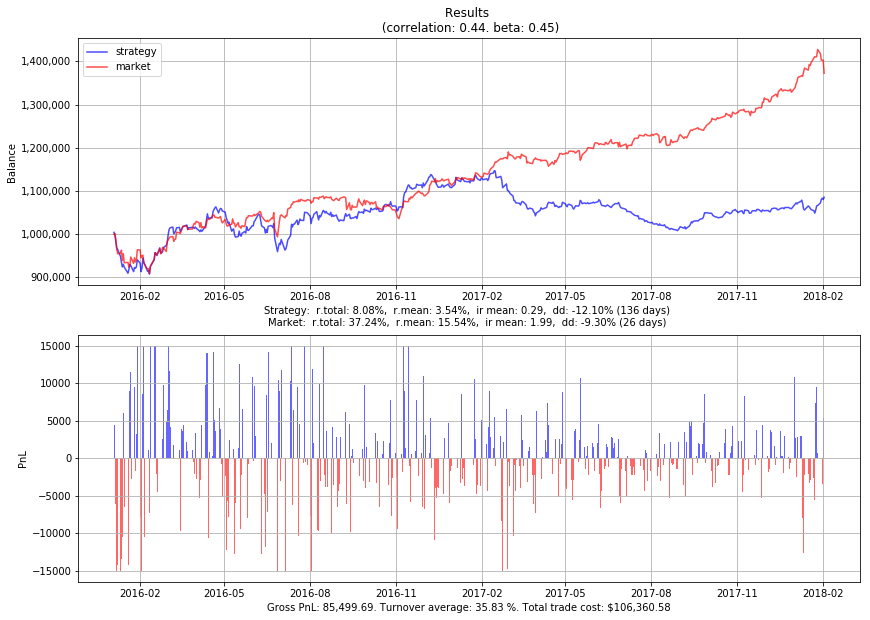

In [5]:
# Show strategy performance.
# : input: sim object.
# : return: plot results
# : store: save report.xlsx (data/pp_data/sim_res/)
Evaluation(strategy).run_evaluation(save_report=True)